# Stock Prediction

<img src="https://cdn.vox-cdn.com/thumbor/DqZ_YBYBAVZtBF1PFi2fj4DOszM=/0x0:1280x800/1200x800/filters:focal(538x298:742x502)/cdn.vox-cdn.com/uploads/chorus_image/image/61897327/apple8.0.png">

In [124]:
%pylab inline
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler 

from keras.models import Sequential    
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *

WINDOW = 30

Populating the interactive namespace from numpy and matplotlib


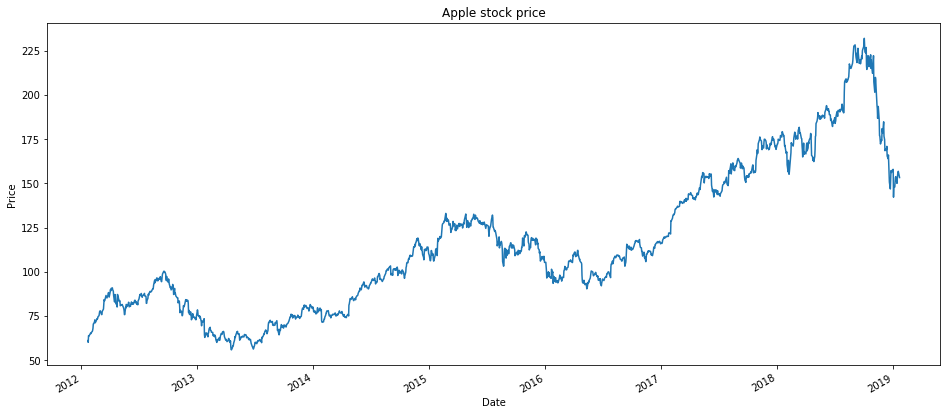

In [125]:
df = pd.read_csv('data/AAPL.csv', index_col=['Date'], parse_dates=['Date']) 

plt.figure(figsize(16,7))
plt.ylabel('Price')
plt.title('Apple stock price')

data = df['Close']

data.plot()
plt.show()

In [126]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-23,60.381428,61.207142,60.328571,61.058571,40.888649,76515600
2012-01-24,60.728573,60.728573,59.935715,60.058571,40.218994,136909500
2012-01-25,64.919998,64.921425,63.389999,63.808571,42.730225,239578500
2012-01-26,64.051430,64.112854,63.305714,63.518570,42.536026,80996300
2012-01-27,63.477142,64.068573,63.395714,63.897144,42.789543,74927300


In [127]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_normalized = scaler.fit_transform(np.expand_dims(data, axis=1))

In [142]:
normalization = True

In [143]:
features = []  
labels = []  
for i in range(WINDOW, len(data)):
    if normalization:
        features.append(data_normalized[i-WINDOW:i])
        labels.append(data_normalized[i])
    else:
        features.append(data[i-WINDOW:i])
        labels.append(data[i])

features, labels = np.array(features), np.array(labels)
features3d = np.reshape(features, (features.shape[0], features.shape[1], 1))

if normalization:   
    features = np.squeeze(features)
    

In [144]:
barrier = int(len(data)*0.75)

Y_train = labels[:barrier]
X_train = features[:barrier]
Y_test = labels[barrier:]
X_test = features[barrier:]

In [145]:
X_train3d, X_test3d = features3d[:barrier], features3d[barrier:]

In [146]:
from keras.layers import Conv1D, Activation, GlobalMaxPool1D, Flatten, MaxPooling1D, GRU

conv_model = Sequential()
conv_model.add(Conv1D(filters=32, kernel_size=3, input_shape=(WINDOW,1), activation='relu'))
conv_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
conv_model.add(MaxPooling1D(pool_size=2))

conv_model.add(Dropout(0.3))

conv_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
conv_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
conv_model.add(MaxPooling1D(pool_size=2))

conv_model.add(Flatten())

conv_model.add(Dense(units=256, activation='relu'))
conv_model.add(Dense(units=1, activation='linear'))

conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [147]:
model = Sequential()
model.add(Dense(units=10, input_dim=WINDOW))
model.add(Dropout(0.3))
model.add(Dense(units=1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [148]:
lstm_model = Sequential()  
lstm_model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, 
                    input_shape=(WINDOW, 1), activation='relu', return_sequences=True))  
lstm_model.add(LSTM(units=100, activation='relu'))  
lstm_model.add(Dense(units=1, activation='linear'))

lstm_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [149]:
EPOCHS_NUM = 100
BATCH_SIZE = 128

In [150]:
%%time
print('Fitting conv model...')
hist_conv = conv_model.fit(X_train3d, Y_train,
                           epochs=EPOCHS_NUM,
                           batch_size=BATCH_SIZE,
                           validation_split=0.2,
                           shuffle=False,
                           verbose=0)
print('Fitting percep model...')
hist_percep = model.fit(X_train, Y_train,
                        epochs=EPOCHS_NUM,
                        batch_size=BATCH_SIZE,
                        validation_split=0.2,
                        shuffle=False,
                        verbose=0)
print('Fitting recurrent model...')
hist_lstm = lstm_model.fit(X_train3d, Y_train,
                           epochs=EPOCHS_NUM,
                           batch_size=BATCH_SIZE,
                           validation_split=0.2,
                           shuffle=False,
                           verbose=0)
print('Done!')

Fitting conv model...
Fitting percep model...
Fitting recurrent model...
Done!
Wall time: 1min 29s


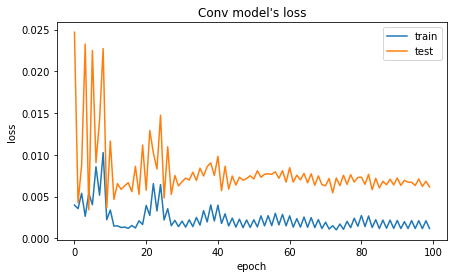

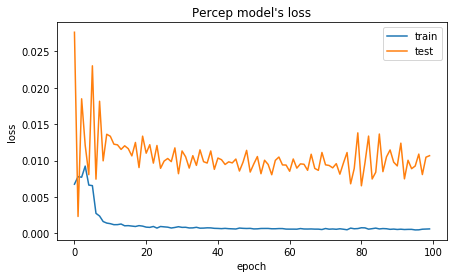

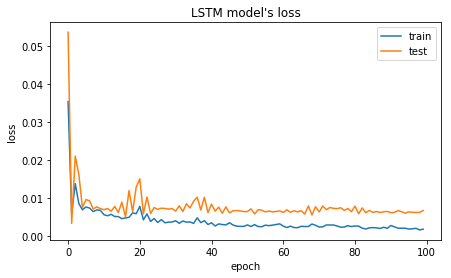

In [151]:
plt.figure(figsize(7,4))

plt.plot(hist_conv.history['loss'])
plt.plot(hist_conv.history['val_loss'])
plt.title('Conv model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(hist_percep.history['loss'])
plt.plot(hist_percep.history['val_loss'])
plt.title('Percep model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(hist_lstm.history['loss'])
plt.plot(hist_lstm.history['val_loss'])
plt.title('LSTM model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [152]:
scores_conv = conv_model.evaluate(X_test3d, Y_test)
scores_percep = model.evaluate(X_test, Y_test)
scores_lstm = lstm_model.evaluate(X_test3d, Y_test)

411/411 [==============================] - 0s 218us/step


In [153]:
print('Conv metric score:\t',scores_conv[1])
print('Perceptron metric score:', scores_percep[1])
print('LSTM metric score:\t', scores_lstm[1])

Conv metric score:	 0.16961902767927398
Perceptron metric score: 0.19225856480517237
LSTM metric score:	 0.12890952999574423


In [154]:
pred_conv = conv_model.predict(X_test3d)
pred_percep = model.predict(X_test) 
pred_lstm = lstm_model.predict(X_test3d) 

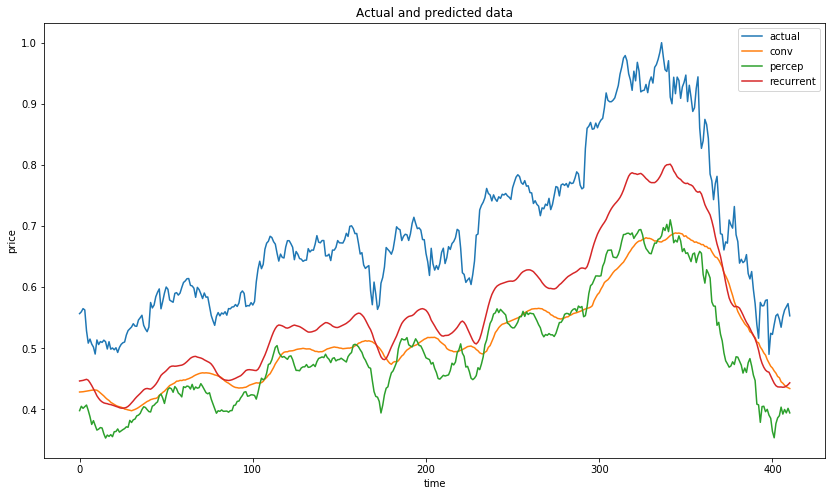

In [155]:
plt.figure(figsize(14,8))
plot(Y_test, label='actual')
plot(pred_conv, label='conv')
plot(pred_percep,label='percep')
plot(pred_lstm,label='recurrent')
plt.title('Actual and predicted data')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()